In [2]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_with_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*6], ctrl_data[:, 17*6]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*6,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-31 14:39:17.234976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21437 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-31 14:39:17.236641: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21447 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-31 14:39:17.238189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21447 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-31 14:39:17.239613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21323 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-31 14:39:45.409731: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:45.431112: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:45.456508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:45.491712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:48.698303: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdc1747dee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-31 14:39:48.698331: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:39:48.698337: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:39:48.69834

3/3 [==============================] - ETA: 0s - loss: 26.6051INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-01-29.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-01-29.76/assets


3/3 [==============================] - 49s 7s/step - loss: 26.6051 - val_loss: 29.7634 - lr: 0.0010
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 24.3757INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-02-29.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-02-29.68/assets


3/3 [==============================] - 9s 5s/step - loss: 24.3037 - val_loss: 29.6838 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 22.0131INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-03-29.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-03-29.50/assets


3/3 [==============================] - 10s 5s/step - loss: 22.0131 - val_loss: 29.5032 - lr: 0.0010
Epoch 4/1000
2/3 [===================>..........] - ETA: 0s - loss: 19.5078INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-04-29.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-04-29.12/assets


3/3 [==============================] - 10s 5s/step - loss: 19.4493 - val_loss: 29.1201 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 17.9290INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-05-28.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-05-28.52/assets


3/3 [==============================] - 10s 5s/step - loss: 17.9290 - val_loss: 28.5220 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 17.2610INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-06-27.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-06-27.77/assets


3/3 [==============================] - 10s 5s/step - loss: 17.2610 - val_loss: 27.7674 - lr: 0.0010
Epoch 7/1000
2/3 [===================>..........] - ETA: 0s - loss: 16.8452INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-07-26.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-07-26.95/assets


3/3 [==============================] - 10s 5s/step - loss: 16.8121 - val_loss: 26.9507 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 16.4402INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-08-26.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-08-26.18/assets


3/3 [==============================] - 10s 5s/step - loss: 16.4402 - val_loss: 26.1767 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 16.1065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-09-25.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-09-25.52/assets


3/3 [==============================] - 10s 5s/step - loss: 16.1065 - val_loss: 25.5175 - lr: 0.0010
Epoch 10/1000
2/3 [===================>..........] - ETA: 0s - loss: 15.8149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-10-25.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-10-25.01/assets


3/3 [==============================] - 10s 5s/step - loss: 15.7765 - val_loss: 25.0125 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 15.4540INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-11-24.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-11-24.63/assets


3/3 [==============================] - 10s 5s/step - loss: 15.4540 - val_loss: 24.6321 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 15.1430INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-12-24.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-12-24.35/assets


3/3 [==============================] - 10s 5s/step - loss: 15.1430 - val_loss: 24.3505 - lr: 0.0010
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 14.8373INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-13-24.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-13-24.15/assets


3/3 [==============================] - 10s 5s/step - loss: 14.8373 - val_loss: 24.1491 - lr: 0.0010
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 14.5301INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-14-23.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-14-23.94/assets


3/3 [==============================] - 10s 5s/step - loss: 14.5301 - val_loss: 23.9438 - lr: 0.0010
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 14.2214INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-15-23.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-15-23.76/assets


3/3 [==============================] - 10s 5s/step - loss: 14.2214 - val_loss: 23.7618 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 13.9125INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-16-23.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-16-23.57/assets


3/3 [==============================] - 10s 5s/step - loss: 13.9125 - val_loss: 23.5749 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 13.6146INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-17-23.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-17-23.38/assets


3/3 [==============================] - 10s 5s/step - loss: 13.6146 - val_loss: 23.3762 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 13.3340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-18-23.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-18-23.15/assets


3/3 [==============================] - 10s 5s/step - loss: 13.3340 - val_loss: 23.1535 - lr: 0.0010
Epoch 19/1000
2/3 [===================>..........] - ETA: 0s - loss: 13.0966INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-19-22.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-19-22.92/assets


3/3 [==============================] - 10s 5s/step - loss: 13.0692 - val_loss: 22.9185 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 12.8205INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-20-22.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-20-22.71/assets


3/3 [==============================] - 9s 4s/step - loss: 12.8205 - val_loss: 22.7079 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 12.5790INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-21-22.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-21-22.46/assets


3/3 [==============================] - 10s 5s/step - loss: 12.5790 - val_loss: 22.4583 - lr: 0.0010
Epoch 22/1000
2/3 [===================>..........] - ETA: 0s - loss: 12.3603INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-22-22.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-22-22.22/assets


3/3 [==============================] - 11s 5s/step - loss: 12.3438 - val_loss: 22.2203 - lr: 0.0010
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 12.1106INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-23-21.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-23-21.91/assets


3/3 [==============================] - 9s 4s/step - loss: 12.1106 - val_loss: 21.9125 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 11.8728INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-24-21.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-24-21.62/assets


3/3 [==============================] - 10s 5s/step - loss: 11.8728 - val_loss: 21.6205 - lr: 0.0010
Epoch 25/1000
2/3 [===================>..........] - ETA: 0s - loss: 11.6409INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-25-21.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-25-21.35/assets


3/3 [==============================] - 10s 5s/step - loss: 11.6411 - val_loss: 21.3537 - lr: 0.0010
Epoch 26/1000
2/3 [===================>..........] - ETA: 0s - loss: 11.4243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-26-21.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-26-21.17/assets


3/3 [==============================] - 10s 5s/step - loss: 11.4079 - val_loss: 21.1730 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 11.1798INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-27-20.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-27-20.93/assets


3/3 [==============================] - 10s 5s/step - loss: 11.1798 - val_loss: 20.9277 - lr: 0.0010
Epoch 28/1000
2/3 [===================>..........] - ETA: 0s - loss: 10.9530INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-28-20.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-28-20.71/assets


3/3 [==============================] - 10s 5s/step - loss: 10.9558 - val_loss: 20.7149 - lr: 0.0010
Epoch 29/1000
2/3 [===================>..........] - ETA: 0s - loss: 10.7533INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-29-20.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-29-20.40/assets


3/3 [==============================] - 10s 5s/step - loss: 10.7361 - val_loss: 20.4031 - lr: 0.0010
Epoch 30/1000
3/3 [==============================] - ETA: 0s - loss: 10.5198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-30-20.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-30-20.13/assets


3/3 [==============================] - 10s 5s/step - loss: 10.5198 - val_loss: 20.1253 - lr: 0.0010
Epoch 31/1000
2/3 [===================>..........] - ETA: 0s - loss: 10.3225INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-31-19.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-31-19.86/assets


3/3 [==============================] - 10s 5s/step - loss: 10.3060 - val_loss: 19.8578 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 10.0960INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-32-19.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-32-19.54/assets


3/3 [==============================] - 10s 5s/step - loss: 10.0960 - val_loss: 19.5368 - lr: 0.0010
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 9.8890INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-33-19.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-33-19.32/assets


3/3 [==============================] - 10s 5s/step - loss: 9.8890 - val_loss: 19.3246 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 9.6844INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-34-19.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-34-19.03/assets


3/3 [==============================] - 10s 5s/step - loss: 9.6844 - val_loss: 19.0256 - lr: 0.0010
Epoch 35/1000
2/3 [===================>..........] - ETA: 0s - loss: 9.5307INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-35-18.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-35-18.77/assets


3/3 [==============================] - 9s 4s/step - loss: 9.4846 - val_loss: 18.7721 - lr: 0.0010
Epoch 36/1000
2/3 [===================>..........] - ETA: 0s - loss: 9.3165INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-36-18.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-36-18.54/assets


3/3 [==============================] - 11s 5s/step - loss: 9.2847 - val_loss: 18.5438 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 9.0910INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-37-18.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-37-18.25/assets


3/3 [==============================] - 10s 5s/step - loss: 9.0910 - val_loss: 18.2455 - lr: 0.0010
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 8.8971INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-38-18.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-38-18.01/assets


3/3 [==============================] - 10s 5s/step - loss: 8.8971 - val_loss: 18.0140 - lr: 0.0010
Epoch 39/1000
3/3 [==============================] - ETA: 0s - loss: 8.7002INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-39-17.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-39-17.70/assets


3/3 [==============================] - 10s 5s/step - loss: 8.7002 - val_loss: 17.6986 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 8.5091INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-40-17.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-40-17.50/assets


3/3 [==============================] - 10s 5s/step - loss: 8.5091 - val_loss: 17.5028 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 8.3191INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-41-17.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-41-17.29/assets


3/3 [==============================] - 9s 4s/step - loss: 8.3191 - val_loss: 17.2856 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 8.1316INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-42-17.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-42-17.11/assets


3/3 [==============================] - 11s 5s/step - loss: 8.1316 - val_loss: 17.1123 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 7.9465INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-43-16.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-43-16.88/assets


3/3 [==============================] - 10s 5s/step - loss: 7.9465 - val_loss: 16.8817 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 7.7616INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-44-16.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-44-16.79/assets


3/3 [==============================] - 10s 5s/step - loss: 7.7616 - val_loss: 16.7859 - lr: 0.0010
Epoch 45/1000
3/3 [==============================] - ETA: 0s - loss: 7.5783INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-45-16.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-45-16.57/assets


3/3 [==============================] - 9s 4s/step - loss: 7.5783 - val_loss: 16.5673 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 7.3969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-46-16.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-46-16.45/assets


3/3 [==============================] - 11s 5s/step - loss: 7.3969 - val_loss: 16.4486 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 7.2155INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-47-16.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-47-16.18/assets


3/3 [==============================] - 10s 5s/step - loss: 7.2155 - val_loss: 16.1786 - lr: 0.0010
Epoch 48/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.0744INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-48-16.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-48-16.10/assets


3/3 [==============================] - 9s 4s/step - loss: 7.0382 - val_loss: 16.0958 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 6.8634INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-49-15.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-49-15.89/assets


3/3 [==============================] - 11s 5s/step - loss: 6.8634 - val_loss: 15.8881 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - ETA: 0s - loss: 6.6908INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-50-15.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-50-15.73/assets


3/3 [==============================] - 11s 5s/step - loss: 6.6908 - val_loss: 15.7344 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 6.5199INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-51-15.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-51-15.46/assets


3/3 [==============================] - 11s 5s/step - loss: 6.5199 - val_loss: 15.4609 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 6.3521INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-52-15.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-52-15.22/assets


3/3 [==============================] - 9s 4s/step - loss: 6.3521 - val_loss: 15.2186 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 6.1899INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-53-14.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-53-14.99/assets


3/3 [==============================] - 11s 5s/step - loss: 6.1899 - val_loss: 14.9894 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 6.0302INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-54-14.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-54-14.76/assets


3/3 [==============================] - 11s 5s/step - loss: 6.0302 - val_loss: 14.7623 - lr: 0.0010
Epoch 55/1000
2/3 [===================>..........] - ETA: 0s - loss: 5.8647INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-55-14.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-55-14.58/assets


3/3 [==============================] - 9s 4s/step - loss: 5.8710 - val_loss: 14.5848 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 5.7152INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-56-14.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-56-14.30/assets


3/3 [==============================] - 11s 5s/step - loss: 5.7152 - val_loss: 14.3034 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 5.5601INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-57-14.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-57-14.04/assets


3/3 [==============================] - 11s 5s/step - loss: 5.5601 - val_loss: 14.0372 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 5.4128INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-58-13.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-58-13.73/assets


3/3 [==============================] - 9s 4s/step - loss: 5.4128 - val_loss: 13.7259 - lr: 0.0010
Epoch 59/1000
2/3 [===================>..........] - ETA: 0s - loss: 5.2729INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-59-13.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-59-13.49/assets


3/3 [==============================] - 11s 5s/step - loss: 5.2672 - val_loss: 13.4881 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 5.1204INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-60-13.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-60-13.25/assets


3/3 [==============================] - 11s 5s/step - loss: 5.1204 - val_loss: 13.2495 - lr: 0.0010
Epoch 61/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.9839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-61-13.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-61-13.17/assets


3/3 [==============================] - 9s 4s/step - loss: 4.9775 - val_loss: 13.1669 - lr: 0.0010
Epoch 62/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.8452INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-62-12.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-62-12.92/assets


3/3 [==============================] - 11s 5s/step - loss: 4.8380 - val_loss: 12.9173 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 4.7011INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-63-12.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-63-12.57/assets


3/3 [==============================] - 11s 5s/step - loss: 4.7011 - val_loss: 12.5708 - lr: 0.0010
Epoch 64/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.5611INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-64-12.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-64-12.35/assets


3/3 [==============================] - 9s 4s/step - loss: 4.5663 - val_loss: 12.3484 - lr: 0.0010
Epoch 65/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.4300INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-65-12.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-65-12.06/assets


3/3 [==============================] - 11s 5s/step - loss: 4.4324 - val_loss: 12.0592 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 4.3034INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-66-11.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-66-11.78/assets


3/3 [==============================] - 9s 4s/step - loss: 4.3034 - val_loss: 11.7812 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 4.1761INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-67-11.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-67-11.57/assets


3/3 [==============================] - 11s 6s/step - loss: 4.1761 - val_loss: 11.5743 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 4.0534INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-68-11.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-68-11.32/assets


3/3 [==============================] - 11s 5s/step - loss: 4.0534 - val_loss: 11.3162 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 3.9291INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-69-11.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-69-11.09/assets


3/3 [==============================] - 9s 4s/step - loss: 3.9291 - val_loss: 11.0905 - lr: 0.0010
Epoch 70/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.8107INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-70-10.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-70-10.80/assets


3/3 [==============================] - 11s 5s/step - loss: 3.8082 - val_loss: 10.7992 - lr: 0.0010
Epoch 71/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.6906INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-71-10.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-71-10.63/assets


3/3 [==============================] - 9s 4s/step - loss: 3.6910 - val_loss: 10.6271 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 3.5763INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-72-10.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-72-10.33/assets


3/3 [==============================] - 11s 6s/step - loss: 3.5763 - val_loss: 10.3293 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 3.4636INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-73-10.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-73-10.02/assets


3/3 [==============================] - 11s 5s/step - loss: 3.4636 - val_loss: 10.0192 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 3.3549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-74-9.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-74-9.89/assets


3/3 [==============================] - 9s 4s/step - loss: 3.3549 - val_loss: 9.8893 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 3.2477INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-75-9.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-75-9.78/assets


3/3 [==============================] - 11s 6s/step - loss: 3.2477 - val_loss: 9.7818 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 3.1433INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-76-9.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-76-9.49/assets


3/3 [==============================] - 9s 4s/step - loss: 3.1433 - val_loss: 9.4922 - lr: 0.0010
Epoch 77/1000
3/3 [==============================] - ETA: 0s - loss: 3.0429INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-77-9.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-77-9.38/assets


3/3 [==============================] - 11s 6s/step - loss: 3.0429 - val_loss: 9.3780 - lr: 0.0010
Epoch 78/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.9420INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-78-9.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-78-9.04/assets


3/3 [==============================] - 9s 4s/step - loss: 2.9431 - val_loss: 9.0418 - lr: 0.0010
Epoch 79/1000
3/3 [==============================] - ETA: 0s - loss: 2.8467INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-79-8.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-79-8.70/assets


3/3 [==============================] - 11s 6s/step - loss: 2.8467 - val_loss: 8.7017 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 2.7513INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-80-8.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-80-8.51/assets


3/3 [==============================] - 11s 5s/step - loss: 2.7513 - val_loss: 8.5120 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 2.6586INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-81-8.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-81-8.35/assets


3/3 [==============================] - 9s 4s/step - loss: 2.6586 - val_loss: 8.3477 - lr: 0.0010
Epoch 82/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.5864INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-82-8.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-82-8.25/assets


3/3 [==============================] - 11s 6s/step - loss: 2.5701 - val_loss: 8.2466 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 2.4822INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-83-7.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-83-7.96/assets


3/3 [==============================] - 9s 4s/step - loss: 2.4822 - val_loss: 7.9561 - lr: 0.0010
Epoch 84/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.3936INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-84-7.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-84-7.74/assets


3/3 [==============================] - 11s 6s/step - loss: 2.3941 - val_loss: 7.7422 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 2.3087INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-85-7.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-85-7.57/assets


3/3 [==============================] - 9s 4s/step - loss: 2.3087 - val_loss: 7.5696 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 2.2271INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-86-7.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-86-7.43/assets


3/3 [==============================] - 11s 6s/step - loss: 2.2271 - val_loss: 7.4336 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 2.1471INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-87-7.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-87-7.32/assets


3/3 [==============================] - 9s 4s/step - loss: 2.1471 - val_loss: 7.3197 - lr: 0.0010
Epoch 88/1000
3/3 [==============================] - ETA: 0s - loss: 2.0719INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-88-7.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-88-7.14/assets


3/3 [==============================] - 11s 6s/step - loss: 2.0719 - val_loss: 7.1409 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 1.9961INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-89-6.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-89-6.98/assets


3/3 [==============================] - 9s 4s/step - loss: 1.9961 - val_loss: 6.9772 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 1.9248INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-90-6.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-90-6.73/assets


3/3 [==============================] - 11s 6s/step - loss: 1.9248 - val_loss: 6.7288 - lr: 0.0010
Epoch 91/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.8708INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-91-6.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-91-6.59/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8532 - val_loss: 6.5877 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 1.7845INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-92-6.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-92-6.38/assets


3/3 [==============================] - 12s 6s/step - loss: 1.7845 - val_loss: 6.3822 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 1.7197INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-93-6.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-93-6.26/assets


3/3 [==============================] - 9s 4s/step - loss: 1.7197 - val_loss: 6.2608 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 1.6523INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-94-6.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-94-6.14/assets


3/3 [==============================] - 11s 6s/step - loss: 1.6523 - val_loss: 6.1389 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - 0s 191ms/step - loss: 1.5903 - val_loss: 6.1420 - lr: 0.0010
Epoch 96/1000
3/3 [==============================] - ETA: 0s - loss: 1.5336INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-96-5.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-96-5.83/assets


3/3 [==============================] - 9s 4s/step - loss: 1.5336 - val_loss: 5.8304 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 1.4738INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-97-5.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-97-5.63/assets


3/3 [==============================] - 11s 6s/step - loss: 1.4738 - val_loss: 5.6302 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - ETA: 0s - loss: 1.4170INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-98-5.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-98-5.48/assets


3/3 [==============================] - 11s 6s/step - loss: 1.4170 - val_loss: 5.4751 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 1.3617INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-99-5.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-99-5.32/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3617 - val_loss: 5.3230 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 1.3087INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-100-5.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-100-5.11/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3087 - val_loss: 5.1060 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - ETA: 0s - loss: 1.2564INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-101-4.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-101-4.94/assets


3/3 [==============================] - 12s 6s/step - loss: 1.2564 - val_loss: 4.9392 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 1.2086INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-102-4.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-102-4.81/assets


3/3 [==============================] - 11s 6s/step - loss: 1.2086 - val_loss: 4.8120 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 1.1596INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-103-4.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-103-4.71/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1596 - val_loss: 4.7131 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 1.1160INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-104-4.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-104-4.46/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1160 - val_loss: 4.4643 - lr: 0.0010
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 1.0673INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-105-4.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-105-4.45/assets


3/3 [==============================] - 12s 6s/step - loss: 1.0673 - val_loss: 4.4456 - lr: 0.0010
Epoch 106/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0226INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-106-4.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-106-4.36/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0250 - val_loss: 4.3589 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.9832INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-107-4.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-107-4.18/assets


3/3 [==============================] - 12s 6s/step - loss: 0.9832 - val_loss: 4.1819 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - ETA: 0s - loss: 0.9427INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-108-4.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-108-4.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9427 - val_loss: 4.0620 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.9040INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-109-3.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-109-3.90/assets


3/3 [==============================] - 12s 6s/step - loss: 0.9040 - val_loss: 3.8994 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 0.8675INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-110-3.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-110-3.85/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8675 - val_loss: 3.8542 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - ETA: 0s - loss: 0.8319INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-111-3.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-111-3.71/assets


3/3 [==============================] - 12s 6s/step - loss: 0.8319 - val_loss: 3.7063 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 0.7989INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-112-3.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-112-3.58/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7989 - val_loss: 3.5843 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.7659INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-113-3.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-113-3.29/assets


3/3 [==============================] - 12s 6s/step - loss: 0.7659 - val_loss: 3.2923 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.7401 - val_loss: 3.3386 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 0.7058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-115-3.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-115-3.16/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7058 - val_loss: 3.1589 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 0.6738INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-116-3.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-116-3.09/assets


3/3 [==============================] - 12s 6s/step - loss: 0.6738 - val_loss: 3.0858 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.6452INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-117-2.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-117-2.96/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6452 - val_loss: 2.9628 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.6200INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-118-2.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-118-2.87/assets


3/3 [==============================] - 12s 6s/step - loss: 0.6200 - val_loss: 2.8703 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.5925 - val_loss: 2.8789 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 0.5678INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-120-2.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-120-2.78/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5678 - val_loss: 2.7761 - lr: 0.0010
Epoch 121/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.5522INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-121-2.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-121-2.73/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5439 - val_loss: 2.7270 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.5241INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-122-2.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-122-2.49/assets


3/3 [==============================] - 12s 6s/step - loss: 0.5241 - val_loss: 2.4873 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.5000INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-123-2.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-123-2.37/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5000 - val_loss: 2.3709 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.4836INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-124-2.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-124-2.31/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4836 - val_loss: 2.3074 - lr: 0.0010
Epoch 125/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.4582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-125-2.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-125-2.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4586 - val_loss: 2.2601 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 0.4408INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-126-2.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-126-2.18/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4408 - val_loss: 2.1788 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.4248INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-127-2.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-127-2.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4248 - val_loss: 2.0886 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - ETA: 0s - loss: 0.4076INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-128-2.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-128-2.06/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4076 - val_loss: 2.0641 - lr: 0.0010
Epoch 129/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3914INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-129-1.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-129-1.94/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3898 - val_loss: 1.9412 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.3755INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-130-1.90/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-130-1.90/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3755 - val_loss: 1.9016 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.3601INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-131-1.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-131-1.84/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3601 - val_loss: 1.8374 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - ETA: 0s - loss: 0.3446INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-132-1.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-132-1.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3446 - val_loss: 1.8347 - lr: 0.0010
Epoch 133/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3344INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-133-1.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-133-1.68/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3315 - val_loss: 1.6791 - lr: 0.0010
Epoch 134/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3167INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-134-1.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-134-1.59/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3178 - val_loss: 1.5851 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 0.3090INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-135-1.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-135-1.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3090 - val_loss: 1.5328 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.2960INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-136-1.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-136-1.48/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2960 - val_loss: 1.4772 - lr: 0.0010
Epoch 137/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2855INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-137-1.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-137-1.48/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2830 - val_loss: 1.4753 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 0.2740INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-138-1.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-138-1.41/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2740 - val_loss: 1.4107 - lr: 0.0010
Epoch 139/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2660INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-139-1.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-139-1.40/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2631 - val_loss: 1.3957 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.2544INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-140-1.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-140-1.24/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2544 - val_loss: 1.2381 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.2473INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-141-1.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-141-1.22/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2473 - val_loss: 1.2235 - lr: 0.0010
Epoch 142/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2412INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-142-1.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-142-1.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2382 - val_loss: 1.2024 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 0.2311INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-143-1.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-143-1.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2311 - val_loss: 1.1523 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 0.2216INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-144-1.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-144-1.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2216 - val_loss: 1.0859 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 0.2147INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-145-0.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-145-0.98/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2147 - val_loss: 0.9769 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.2095 - val_loss: 1.0740 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.2033INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-147-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-147-0.94/assets


3/3 [==============================] - 13s 6s/step - loss: 0.2033 - val_loss: 0.9381 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.1965INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-148-0.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-148-0.86/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1965 - val_loss: 0.8616 - lr: 0.0010
Epoch 149/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1908INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-149-0.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-149-0.84/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1895 - val_loss: 0.8378 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - ETA: 0s - loss: 0.1837INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-150-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-150-0.79/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1837 - val_loss: 0.7911 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 0.1781INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-151-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-151-0.77/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1781 - val_loss: 0.7724 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 0.1718INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-152-0.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-152-0.75/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1718 - val_loss: 0.7467 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.1679 - val_loss: 0.7625 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.1635INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-154-0.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-154-0.70/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1635 - val_loss: 0.7027 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.1587 - val_loss: 0.7037 - lr: 0.0010
Epoch 156/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1564INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-156-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-156-0.66/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1551 - val_loss: 0.6625 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 0.1510INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-157-0.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-157-0.60/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1510 - val_loss: 0.5994 - lr: 0.0010
Epoch 158/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-158-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-158-0.59/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1489 - val_loss: 0.5888 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.1440INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-159-0.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-159-0.58/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1440 - val_loss: 0.5818 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.1427 - val_loss: 0.6098 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - ETA: 0s - loss: 0.1391INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-161-0.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-161-0.58/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1391 - val_loss: 0.5789 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - ETA: 0s - loss: 0.1380INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-162-0.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-162-0.50/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1380 - val_loss: 0.5016 - lr: 0.0010
Epoch 163/1000
3/3 [==============================] - ETA: 0s - loss: 0.1342INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-163-0.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-163-0.50/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1342 - val_loss: 0.4986 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.1324 - val_loss: 0.5188 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.1321 - val_loss: 0.5452 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - ETA: 0s - loss: 0.1298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-166-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-166-0.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1298 - val_loss: 0.4220 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - ETA: 0s - loss: 0.1264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-167-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-167-0.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1264 - val_loss: 0.4160 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - ETA: 0s - loss: 0.1251INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-168-0.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-168-0.39/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1251 - val_loss: 0.3937 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 0.1213INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-169-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-169-0.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1213 - val_loss: 0.3825 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.1187 - val_loss: 0.3875 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.1183 - val_loss: 0.4029 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - ETA: 0s - loss: 0.1173INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-172-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-172-0.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1173 - val_loss: 0.3771 - lr: 0.0010
Epoch 173/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1141INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-173-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-173-0.35/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1160 - val_loss: 0.3453 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.1163 - val_loss: 0.3477 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - ETA: 0s - loss: 0.1128INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-175-0.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-175-0.34/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1128 - val_loss: 0.3366 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - ETA: 0s - loss: 0.1105INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-176-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-176-0.32/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1105 - val_loss: 0.3164 - lr: 0.0010
Epoch 177/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1121INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-177-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-177-0.31/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1113 - val_loss: 0.3058 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.1108 - val_loss: 0.3128 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 0.1087INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-179-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-179-0.27/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1087 - val_loss: 0.2750 - lr: 0.0010
Epoch 180/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1068INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-180-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-180-0.27/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1072 - val_loss: 0.2730 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.1078 - val_loss: 0.2738 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 0.1065INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-182-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-182-0.27/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1065 - val_loss: 0.2730 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - ETA: 0s - loss: 0.1058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-183-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-183-0.26/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1058 - val_loss: 0.2644 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.1066 - val_loss: 0.2697 - lr: 0.0010
Epoch 185/1000
3/3 [==============================] - ETA: 0s - loss: 0.1052INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-185-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-185-0.24/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1052 - val_loss: 0.2371 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.1062 - val_loss: 0.2398 - lr: 0.0010
Epoch 187/1000
3/3 [==============================] - ETA: 0s - loss: 0.1036INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-187-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-187-0.23/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1036 - val_loss: 0.2310 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.1050 - val_loss: 0.2401 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - ETA: 0s - loss: 0.1037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-189-0.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-189-0.22/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1037 - val_loss: 0.2156 - lr: 0.0010
Epoch 190/1000
3/3 [==============================] - ETA: 0s - loss: 0.1027INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-190-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-190-0.21/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1027 - val_loss: 0.2117 - lr: 0.0010
Epoch 191/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.1037 - val_loss: 0.2281 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 0.1022INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-192-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-192-0.19/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1022 - val_loss: 0.1865 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - ETA: 0s - loss: 0.1014INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-193-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-193-0.18/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1014 - val_loss: 0.1823 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.1021 - val_loss: 0.2217 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.1001 - val_loss: 0.2068 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - ETA: 0s - loss: 0.1009INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-196-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-196-0.18/assets


3/3 [==============================] - 13s 7s/step - loss: 0.1009 - val_loss: 0.1760 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.1006 - val_loss: 0.1782 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0995 - val_loss: 0.1790 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0984 - val_loss: 0.1813 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - ETA: 0s - loss: 0.0966INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-200-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-200-0.18/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0966 - val_loss: 0.1753 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - ETA: 0s - loss: 0.0966INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-201-0.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-201-0.17/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0966 - val_loss: 0.1683 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0965 - val_loss: 0.2072 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 1s 220ms/step - loss: 0.0962 - val_loss: 0.1689 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - ETA: 0s - loss: 0.0965INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-204-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-204-0.16/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0965 - val_loss: 0.1585 - lr: 0.0010
Epoch 205/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0963 - val_loss: 0.1631 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - 1s 243ms/step - loss: 0.0954 - val_loss: 0.1633 - lr: 0.0010
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 0.0967INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-207-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-207-0.16/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0967 - val_loss: 0.1565 - lr: 0.0010
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 0.0948INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-208-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-208-0.15/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0948 - val_loss: 0.1493 - lr: 0.0010
Epoch 209/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0950INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-209-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-209-0.14/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0962 - val_loss: 0.1410 - lr: 0.0010
Epoch 210/1000
3/3 [==============================] - ETA: 0s - loss: 0.0963INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-210-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-210-0.14/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0963 - val_loss: 0.1391 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0960 - val_loss: 0.1540 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0961 - val_loss: 0.1458 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0958 - val_loss: 0.1440 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0943 - val_loss: 0.1470 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0956 - val_loss: 0.1522 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - ETA: 0s - loss: 0.0946INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-216-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-216-0.13/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0946 - val_loss: 0.1338 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - ETA: 0s - loss: 0.0970INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-217-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-217-0.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0970 - val_loss: 0.1293 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0966 - val_loss: 0.1419 - lr: 0.0010
Epoch 219/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0952 - val_loss: 0.1364 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - ETA: 0s - loss: 0.0948INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-220-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-220-0.12/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0948 - val_loss: 0.1233 - lr: 0.0010
Epoch 221/1000
3/3 [==============================] - 0s 229ms/step - loss: 0.0958 - val_loss: 0.1488 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0947 - val_loss: 0.1240 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - ETA: 0s - loss: 0.0949INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-223-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-223-0.12/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0949 - val_loss: 0.1221 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0948 - val_loss: 0.1381 - lr: 0.0010
Epoch 225/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0936INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-225-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-225-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0948 - val_loss: 0.1213 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - ETA: 0s - loss: 0.0939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-226-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-226-0.12/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0939 - val_loss: 0.1204 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0938 - val_loss: 0.1293 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0950 - val_loss: 0.1438 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0999 - val_loss: 0.1508 - lr: 0.0010
Epoch 230/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1001INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-230-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-230-0.12/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1001 - val_loss: 0.1198 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 0.0970INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-231-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-231-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0970 - val_loss: 0.1179 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0969 - val_loss: 0.1338 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0975 - val_loss: 0.1192 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0960 - val_loss: 0.1186 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0960 - val_loss: 0.1191 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0945 - val_loss: 0.1209 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 0.0951INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-237-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-237-0.11/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0951 - val_loss: 0.1116 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0946 - val_loss: 0.1216 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0946 - val_loss: 0.1166 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0932 - val_loss: 0.1122 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - ETA: 0s - loss: 0.0930INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-241-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-241-0.11/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0930 - val_loss: 0.1103 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0938 - val_loss: 0.1262 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0942 - val_loss: 0.1104 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - ETA: 0s - loss: 0.0933INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-244-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-244-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0933 - val_loss: 0.1069 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0934 - val_loss: 0.1100 - lr: 0.0010
Epoch 246/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0940 - val_loss: 0.1136 - lr: 0.0010
Epoch 247/1000
3/3 [==============================] - ETA: 0s - loss: 0.0942INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-247-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-247-0.11/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0942 - val_loss: 0.1057 - lr: 0.0010
Epoch 248/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.0926 - val_loss: 0.1112 - lr: 0.0010
Epoch 249/1000
3/3 [==============================] - ETA: 0s - loss: 0.0927INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-249-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-249-0.10/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0927 - val_loss: 0.1030 - lr: 0.0010
Epoch 250/1000
3/3 [==============================] - ETA: 0s - loss: 0.0928INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-250-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-250-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0928 - val_loss: 0.1029 - lr: 0.0010
Epoch 251/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0925 - val_loss: 0.1073 - lr: 0.0010
Epoch 252/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0919 - val_loss: 0.1029 - lr: 0.0010
Epoch 253/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0920INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-253-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-253-0.10/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0922 - val_loss: 0.1015 - lr: 0.0010
Epoch 254/1000
3/3 [==============================] - 1s 256ms/step - loss: 0.0925 - val_loss: 0.1064 - lr: 0.0010
Epoch 255/1000
3/3 [==============================] - ETA: 0s - loss: 0.0935INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-255-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-255-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0935 - val_loss: 0.1014 - lr: 0.0010
Epoch 256/1000
3/3 [==============================] - 1s 239ms/step - loss: 0.0928 - val_loss: 0.1042 - lr: 0.0010
Epoch 257/1000
3/3 [==============================] - ETA: 0s - loss: 0.0937INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-257-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-257-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0937 - val_loss: 0.1002 - lr: 0.0010
Epoch 258/1000
3/3 [==============================] - 1s 248ms/step - loss: 0.0927 - val_loss: 0.1002 - lr: 0.0010
Epoch 259/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0930 - val_loss: 0.1017 - lr: 0.0010
Epoch 260/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0927 - val_loss: 0.1030 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - ETA: 0s - loss: 0.0924INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-261-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-261-0.10/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0924 - val_loss: 0.0988 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0929 - val_loss: 0.1111 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0947 - val_loss: 0.1018 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0942 - val_loss: 0.1045 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0956 - val_loss: 0.1011 - lr: 0.0010
Epoch 266/1000
3/3 [==============================] - 1s 243ms/step - loss: 0.0925 - val_loss: 0.1024 - lr: 0.0010
Epoch 267/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0933 - val_loss: 0.1031 - lr: 0.0010
Epoch 268/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0934 - val_loss: 0.1000 - lr: 0.0010
Epoch 269/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0936 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-271-0.10/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0933 - val_loss: 0.0987 - lr: 0.0010
Epoch 272/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0932 - val_loss: 0.1001 - lr: 0.0010
Epoch 273/1000
3/3 [==============================] - ETA: 0s - loss: 0.0927INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-273-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-273-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0927 - val_loss: 0.0976 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - ETA: 0s - loss: 0.0919INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-274-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-274-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0919 - val_loss: 0.0974 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0930 - val_loss: 0.0989 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0929 - val_loss: 0.0978 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0927 - val_loss: 0.1030 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - 1s 246ms/step - loss: 0.0942 - val_loss: 0.1005 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0934 - val_loss: 0.0983 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0923 - val_loss: 0.1019 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0937 - val_loss: 0.0981 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0925 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-283-0.10/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0931 - val_loss: 0.0974 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - ETA: 0s - loss: 0.0916INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-284-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-284-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0916 - val_loss: 0.0964 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0918 - val_loss: 0.0986 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0922 - val_loss: 0.0972 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0920 - val_loss: 0.0986 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0915 - val_loss: 0.0967 - lr: 0.0010
Epoch 289/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0914 - val_loss: 0.0991 - lr: 0.0010
Epoch 290/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0926 - val_loss: 0.0979 - lr: 0.0010
Epoch 291/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0932 - val_loss: 0.0973 - lr: 0.0010
Epoch 292/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0929 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-294-0.10/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0918 - val_loss: 0.0964 - lr: 0.0010
Epoch 295/1000
3/3 [==============================] - ETA: 0s - loss: 0.0919INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-295-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-295-0.10/assets


3/3 [==============================] - 15s 7s/step - loss: 0.0919 - val_loss: 0.0962 - lr: 0.0010
Epoch 296/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.0917 - val_loss: 0.0968 - lr: 0.0010
Epoch 297/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0932 - val_loss: 0.0980 - lr: 0.0010
Epoch 298/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0924 - val_loss: 0.1029 - lr: 0.0010
Epoch 299/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0929 - val_loss: 0.0988 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0917 - val_loss: 0.1031 - lr: 0.0010
Epoch 301/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0931 - val_loss: 0.1050 - lr: 0.0010
Epoch 302/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0924 - val_loss: 0.0997 - lr: 0.0010
Epoch 303/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0929 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-307-0.10/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0928 - val_loss: 0.0953 - lr: 0.0010
Epoch 308/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0917INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-308-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-308-0.09/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0918 - val_loss: 0.0948 - lr: 0.0010
Epoch 309/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0918 - val_loss: 0.0948 - lr: 0.0010
Epoch 310/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0913 - val_loss: 0.0967 - lr: 0.0010
Epoch 311/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0924 - val_loss: 0.0960 - lr: 0.0010
Epoch 312/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0925INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-312-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-312-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0932 - val_loss: 0.0943 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 1s 259ms/step - loss: 0.0921 - val_loss: 0.0944 - lr: 0.0010
Epoch 314/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0924 - val_loss: 0.0956 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0913 - val_loss: 0.0953 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0917 - val_loss: 0.0957 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0910 - val_loss: 0.1081 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0923 - val_loss: 0.0959 - lr: 0.0010
Epoch 319/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0919 - val_loss: 0.0945 - lr: 0.0010
Epoch 320/1000
3/3 [==============================] - 5s 3s/step - loss: 0.0916 - val_loss: 0.1009

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-340-0.09/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0903 - val_loss: 0.0943 - lr: 0.0010
Epoch 341/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0914 - val_loss: 0.1059 - lr: 0.0010
Epoch 342/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0933 - val_loss: 0.1012 - lr: 0.0010
Epoch 343/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0929 - val_loss: 0.0977 - lr: 0.0010
Epoch 344/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0912 - val_loss: 0.0958 - lr: 0.0010
Epoch 345/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0914 - val_loss: 0.0959 - lr: 0.0010
Epoch 346/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0919 - val_loss: 0.0954 - lr: 0.0010
Epoch 347/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0920 - val_loss: 0.0969 - lr: 0.0010
Epoch 348/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0917 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-350-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0924 - val_loss: 0.0936 - lr: 0.0010
Epoch 351/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0907 - val_loss: 0.0986 - lr: 0.0010
Epoch 352/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0912 - val_loss: 0.0962 - lr: 0.0010
Epoch 353/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0925 - val_loss: 0.0958 - lr: 0.0010
Epoch 354/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.0909 - val_loss: 0.0940 - lr: 0.0010
Epoch 355/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0914 - val_loss: 0.0948 - lr: 0.0010
Epoch 356/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0905 - val_loss: 0.1031 - lr: 0.0010
Epoch 357/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0923 - val_loss: 0.0943 - lr: 0.0010
Epoch 358/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0921 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-383-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0903 - val_loss: 0.0935 - lr: 0.0010
Epoch 384/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0905 - val_loss: 0.0943 - lr: 0.0010
Epoch 385/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0903INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-385-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-385-0.09/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0907 - val_loss: 0.0935 - lr: 0.0010
Epoch 386/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0919 - val_loss: 0.0945 - lr: 0.0010
Epoch 387/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0899INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-387-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-387-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0912 - val_loss: 0.0934 - lr: 0.0010
Epoch 388/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.0905 - val_loss: 0.0952 - lr: 0.0010
Epoch 389/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0905 - val_loss: 0.0937 - lr: 0.0010
Epoch 390/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0925 - val_loss: 0.0980 - lr: 0.0010
Epoch 391/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0914 - val_loss: 0.0983 - lr: 0.0010
Epoch 392/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0912 - val_loss: 0.0954 - lr: 0.0010
Epoch 393/1000
3/3 [==============================] - 1s 251ms/step - loss: 0.0903 - val_loss: 0.0959 - lr: 0.0010
Epoch 394/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0909 - val_loss: 0.0969 - lr: 0.0010
Epoch 395/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0903 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-409-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0906 - val_loss: 0.0932 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0911 - val_loss: 0.0941 - lr: 0.0010
Epoch 411/1000
3/3 [==============================] - 1s 244ms/step - loss: 0.0924 - val_loss: 0.0942 - lr: 0.0010
Epoch 412/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0912INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-412-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-412-0.09/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0915 - val_loss: 0.0932 - lr: 0.0010
Epoch 413/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0906 - val_loss: 0.0960 - lr: 0.0010
Epoch 414/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.0913 - val_loss: 0.0984 - lr: 0.0010
Epoch 415/1000
3/3 [==============================] - ETA: 0s - loss: 0.0900INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-415-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-415-0.09/assets


3/3 [==============================] - 10s 5s/step - loss: 0.0900 - val_loss: 0.0930 - lr: 0.0010
Epoch 416/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0909 - val_loss: 0.0960 - lr: 0.0010
Epoch 417/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0906 - val_loss: 0.0995 - lr: 0.0010
Epoch 418/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0905 - val_loss: 0.0933 - lr: 0.0010
Epoch 419/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0900 - val_loss: 0.0944 - lr: 0.0010
Epoch 420/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0905 - val_loss: 0.0987 - lr: 0.0010
Epoch 421/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0903 - val_loss: 0.0952 - lr: 0.0010
Epoch 422/1000
3/3 [==============================] - ETA: 0s - loss: 0.0904INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-422-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-422-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0904 - val_loss: 0.0928 - lr: 0.0010
Epoch 423/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0906 - val_loss: 0.0978 - lr: 0.0010
Epoch 424/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0907 - val_loss: 0.0934 - lr: 0.0010
Epoch 425/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0907 - val_loss: 0.0977 - lr: 0.0010
Epoch 426/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0912 - val_loss: 0.0946 - lr: 0.0010
Epoch 427/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0917 - val_loss: 0.0946 - lr: 0.0010
Epoch 428/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0914 - val_loss: 0.0943 - lr: 0.0010
Epoch 429/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0903 - val_loss: 0.0931 - lr: 0.0010
Epoch 430/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0910 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-461-0.09/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0900 - val_loss: 0.0927 - lr: 0.0010
Epoch 462/1000
3/3 [==============================] - 1s 237ms/step - loss: 0.0908 - val_loss: 0.0981 - lr: 0.0010
Epoch 463/1000
3/3 [==============================] - ETA: 0s - loss: 0.0921INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-463-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-463-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0921 - val_loss: 0.0926 - lr: 0.0010
Epoch 464/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0922 - val_loss: 0.0957 - lr: 0.0010
Epoch 465/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0914 - val_loss: 0.0930 - lr: 0.0010
Epoch 466/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0904 - val_loss: 0.0990 - lr: 0.0010
Epoch 467/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0912 - val_loss: 0.0961 - lr: 0.0010
Epoch 468/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0913 - val_loss: 0.1010 - lr: 0.0010
Epoch 469/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0915 - val_loss: 0.0939 - lr: 0.0010
Epoch 470/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0910 - val_loss: 0.0939 - lr: 0.0010
Epoch 471/1000
3/3 [==============================] - ETA: 0s - loss: 0.0900INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-471-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0900 - val_loss: 0.0926 - lr: 0.0010
Epoch 472/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0902INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-472-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-472-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0909 - val_loss: 0.0924 - lr: 0.0010
Epoch 473/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0895INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-473-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-473-0.09/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0895 - val_loss: 0.0922 - lr: 0.0010
Epoch 474/1000
3/3 [==============================] - ETA: 0s - loss: 0.0893INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-474-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-474-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0893 - val_loss: 0.0919 - lr: 0.0010
Epoch 475/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0896 - val_loss: 0.0924 - lr: 0.0010
Epoch 476/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0901 - val_loss: 0.0929 - lr: 0.0010
Epoch 477/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0905 - val_loss: 0.0947 - lr: 0.0010
Epoch 478/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0913 - val_loss: 0.0974 - lr: 0.0010
Epoch 479/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0908 - val_loss: 0.0961 - lr: 0.0010
Epoch 480/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0906 - val_loss: 0.0938 - lr: 0.0010
Epoch 481/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0910 - val_loss: 0.0967 - lr: 0.0010
Epoch 482/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0903 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-509-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0898 - val_loss: 0.0919 - lr: 0.0010
Epoch 510/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0898 - val_loss: 0.0920 - lr: 0.0010
Epoch 511/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0904 - val_loss: 0.0919 - lr: 0.0010
Epoch 512/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0908 - val_loss: 0.0944 - lr: 0.0010
Epoch 513/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0897 - val_loss: 0.0921 - lr: 0.0010
Epoch 514/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0904 - val_loss: 0.0935 - lr: 0.0010
Epoch 515/1000
3/3 [==============================] - ETA: 0s - loss: 0.0896INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-515-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-515-0.09/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0896 - val_loss: 0.0912 - lr: 0.0010
Epoch 516/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0899 - val_loss: 0.0925 - lr: 0.0010
Epoch 517/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0903 - val_loss: 0.0920 - lr: 0.0010
Epoch 518/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0896 - val_loss: 0.0928 - lr: 0.0010
Epoch 519/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0892 - val_loss: 0.0922 - lr: 0.0010
Epoch 520/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0909 - val_loss: 0.0937 - lr: 0.0010
Epoch 521/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0900 - val_loss: 0.0967 - lr: 0.0010
Epoch 522/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0924 - val_loss: 0.0916 - lr: 0.0010
Epoch 523/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0897 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-602-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0906 - val_loss: 0.0911 - lr: 0.0010
Epoch 603/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0896 - val_loss: 0.0918 - lr: 0.0010
Epoch 604/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0893 - val_loss: 0.0927 - lr: 0.0010
Epoch 605/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0896INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-605-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-605-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0905 - val_loss: 0.0909 - lr: 0.0010
Epoch 606/1000
3/3 [==============================] - 0s 230ms/step - loss: 0.0903 - val_loss: 0.0922 - lr: 0.0010
Epoch 607/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0913 - val_loss: 0.0924 - lr: 0.0010
Epoch 608/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0903 - val_loss: 0.0937 - lr: 0.0010
Epoch 609/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0897 - val_loss: 0.0917 - lr: 0.0010
Epoch 610/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0891 - val_loss: 0.0916 - lr: 0.0010
Epoch 611/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0900 - val_loss: 0.0918 - lr: 0.0010
Epoch 612/1000
3/3 [==============================] - 0s 176ms/step - loss: 0.0900 - val_loss: 0.0918 - lr: 0.0010
Epoch 613/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0897 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-653-0.09/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0889 - val_loss: 0.0905 - lr: 0.0010
Epoch 654/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0885 - val_loss: 0.0921 - lr: 0.0010
Epoch 655/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0903 - val_loss: 0.0910 - lr: 0.0010
Epoch 656/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0889 - val_loss: 0.0917 - lr: 0.0010
Epoch 657/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0893 - val_loss: 0.0917 - lr: 0.0010
Epoch 658/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0896 - val_loss: 0.0919 - lr: 0.0010
Epoch 659/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0887 - val_loss: 0.0908 - lr: 0.0010
Epoch 660/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0892 - val_loss: 0.0910 - lr: 0.0010
Epoch 661/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0893 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-708-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0894 - val_loss: 0.0905 - lr: 0.0010
Epoch 709/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0897 - val_loss: 0.0914 - lr: 0.0010
Epoch 710/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0895 - val_loss: 0.0907 - lr: 0.0010
Epoch 711/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0885INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-711-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-711-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0886 - val_loss: 0.0902 - lr: 0.0010
Epoch 712/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0890 - val_loss: 0.0902 - lr: 0.0010
Epoch 713/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0899 - val_loss: 0.0955 - lr: 0.0010
Epoch 714/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0892 - val_loss: 0.0916 - lr: 0.0010
Epoch 715/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0889 - val_loss: 0.0953 - lr: 0.0010
Epoch 716/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0895 - val_loss: 0.0973 - lr: 0.0010
Epoch 717/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0898 - val_loss: 0.0920 - lr: 0.0010
Epoch 718/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0895 - val_loss: 0.0932 - lr: 0.0010
Epoch 719/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0913 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-847-0.09/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0889 - val_loss: 0.0902 - lr: 0.0010
Epoch 848/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0900 - val_loss: 0.1042 - lr: 0.0010
Epoch 849/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0903 - val_loss: 0.0916 - lr: 0.0010
Epoch 850/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0910 - val_loss: 0.0909 - lr: 0.0010
Epoch 851/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0894 - val_loss: 0.0919 - lr: 0.0010
Epoch 852/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0896 - val_loss: 0.0931 - lr: 0.0010
Epoch 853/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0898 - val_loss: 0.0916 - lr: 0.0010
Epoch 854/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0890 - val_loss: 0.0919 - lr: 0.0010
Epoch 855/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0898 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-891-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0901 - val_loss: 0.0901 - lr: 0.0010
Epoch 892/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0891 - val_loss: 0.0909 - lr: 0.0010
Epoch 893/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0895 - val_loss: 0.0906 - lr: 0.0010
Epoch 894/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0886 - val_loss: 0.0902 - lr: 0.0010
Epoch 895/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0887 - val_loss: 0.0921 - lr: 0.0010
Epoch 896/1000
3/3 [==============================] - ETA: 0s - loss: 0.0888INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-896-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-896-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0888 - val_loss: 0.0900 - lr: 0.0010
Epoch 897/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0888 - val_loss: 0.0909 - lr: 0.0010
Epoch 898/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0896 - val_loss: 0.0908 - lr: 0.0010
Epoch 899/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0883 - val_loss: 0.0907 - lr: 0.0010
Epoch 900/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0892 - val_loss: 0.0907 - lr: 0.0010
Epoch 901/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0891 - val_loss: 0.0906 - lr: 0.0010
Epoch 902/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0881INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-902-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-902-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0886 - val_loss: 0.0898 - lr: 0.0010
Epoch 903/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0875 - val_loss: 0.0899 - lr: 0.0010
Epoch 904/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0882 - val_loss: 0.0923 - lr: 0.0010
Epoch 905/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0901 - val_loss: 0.0921 - lr: 0.0010
Epoch 906/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0888 - val_loss: 0.0912 - lr: 0.0010
Epoch 907/1000
3/3 [==============================] - 0s 178ms/step - loss: 0.0887 - val_loss: 0.0908 - lr: 0.0010
Epoch 908/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0890 - val_loss: 0.0899 - lr: 0.0010
Epoch 909/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0879 - val_loss: 0.0905 - lr: 0.0010
Epoch 910/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0889 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-983-0.09/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0884 - val_loss: 0.0896 - lr: 0.0010
Epoch 984/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0889 - val_loss: 0.0899 - lr: 0.0010
Epoch 985/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0883 - val_loss: 0.0904 - lr: 0.0010
Epoch 986/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0890 - val_loss: 0.0933 - lr: 0.0010
Epoch 987/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0897 - val_loss: 0.0911 - lr: 0.0010
Epoch 988/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0891 - val_loss: 0.0905 - lr: 0.0010
Epoch 989/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0892 - val_loss: 0.0896 - lr: 0.0010
Epoch 990/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0896 - val_loss: 0.0949 - lr: 0.0010
Epoch 991/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0894 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model-997-0.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0882 - val_loss: 0.0895 - lr: 0.0010
Epoch 998/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0890 - val_loss: 0.0926 - lr: 0.0010
Epoch 999/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0892 - val_loss: 0.0910 - lr: 0.0010
Epoch 1000/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0891 - val_loss: 0.0925 - lr: 0.0010
INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model/assets


' '

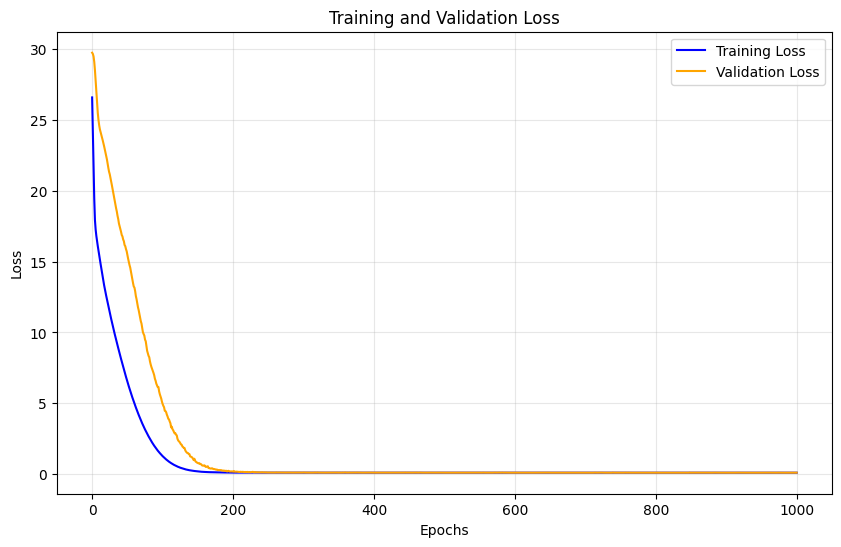

In [4]:
plot_loss(history)

In [5]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Prediction & Performance

In [ ]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input6/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_with_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*6], ctrl_data[:, 17*6]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

In [7]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [8]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [9]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


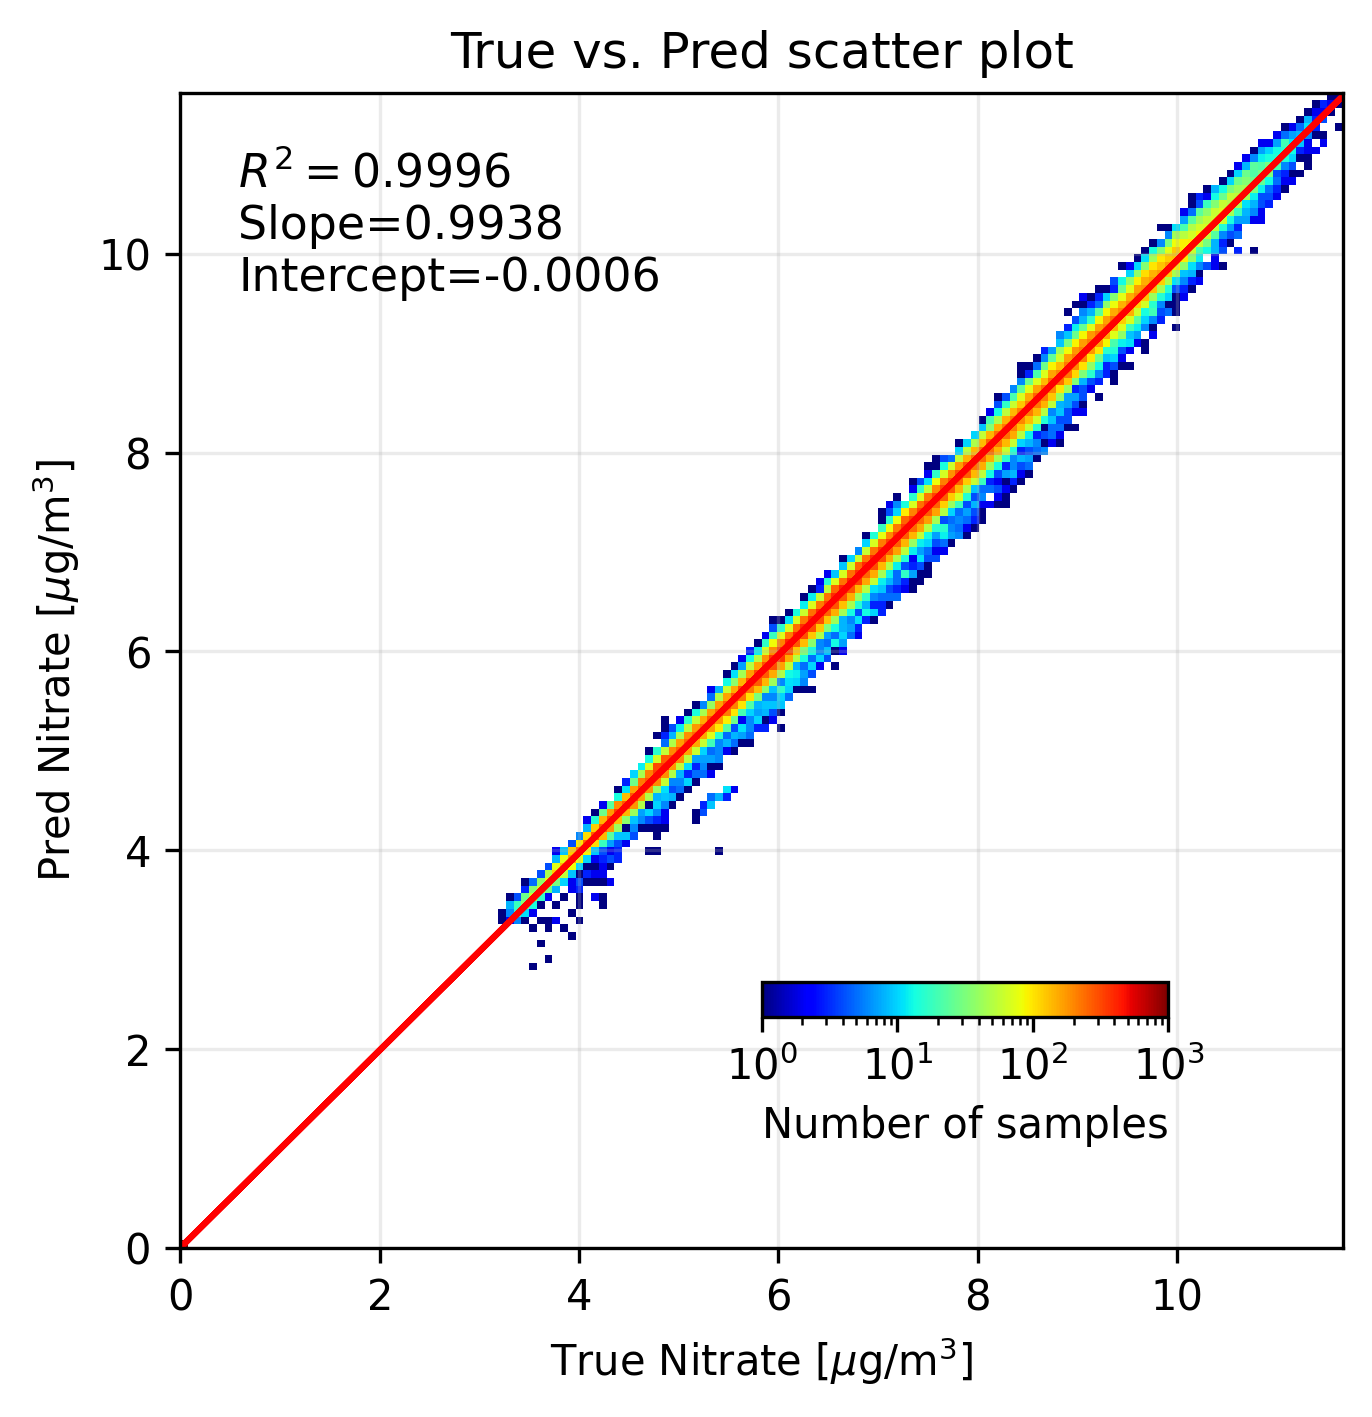

In [10]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

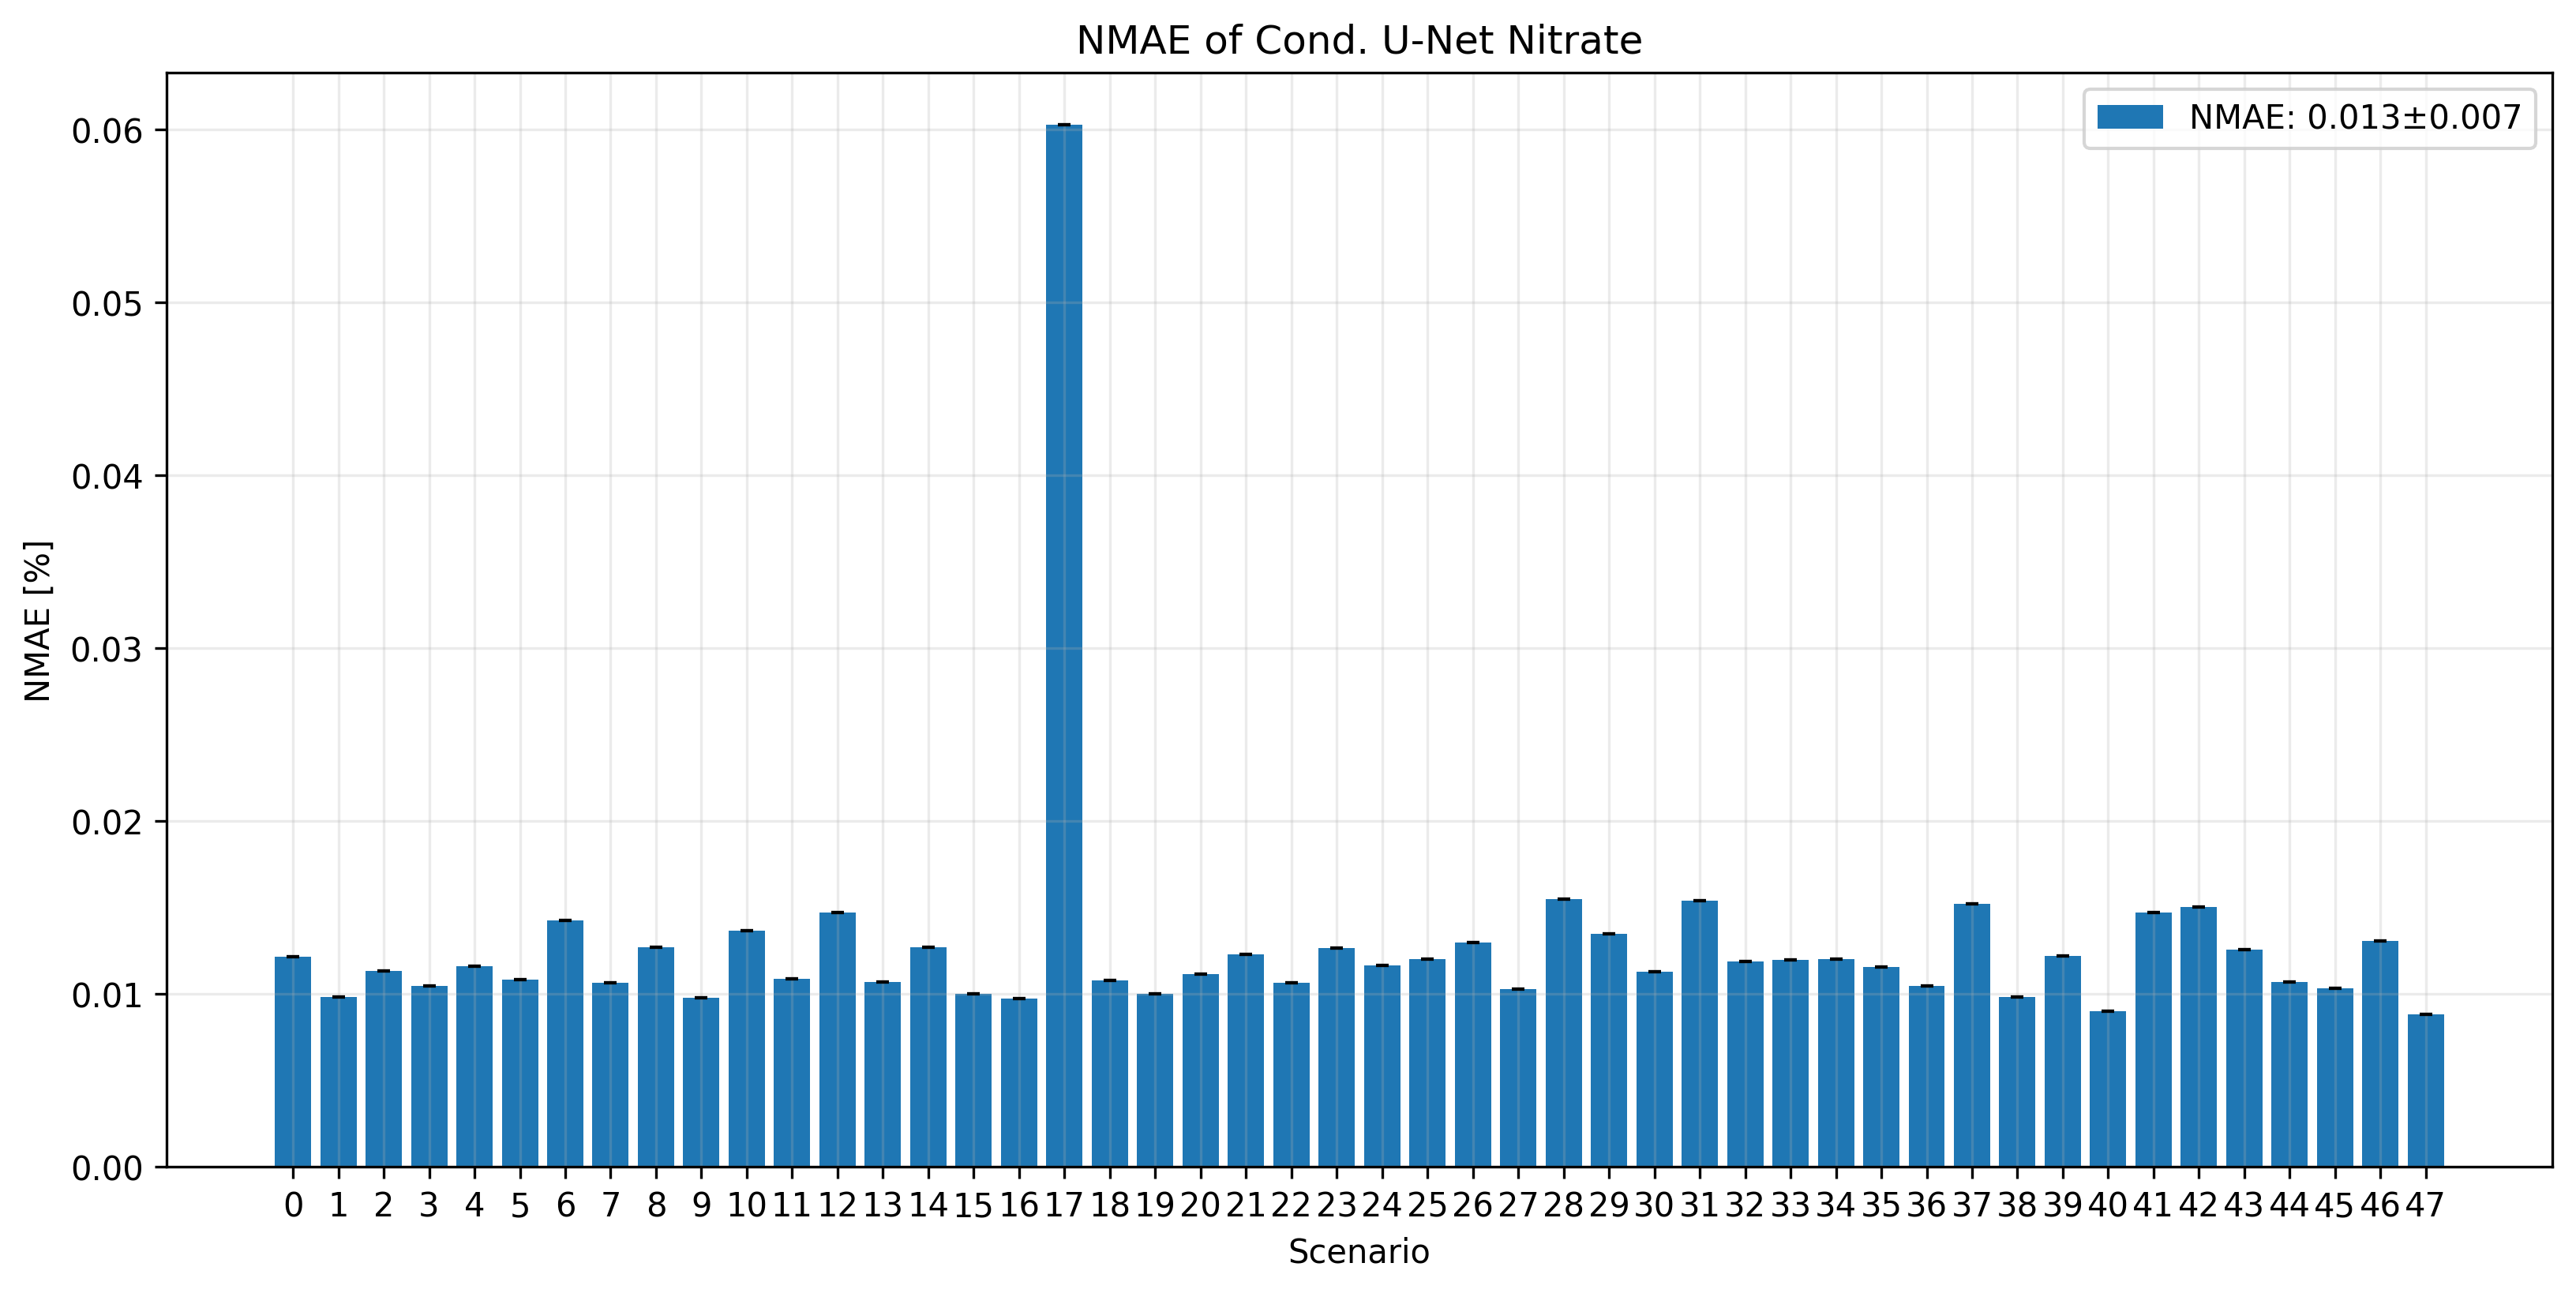

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

[0]


/tmp/ipykernel_1462047/815748241.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462047/815748241.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462047/815748241.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462047/815748241.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462047/815748241.py:67: UserWarning: set_ticklab

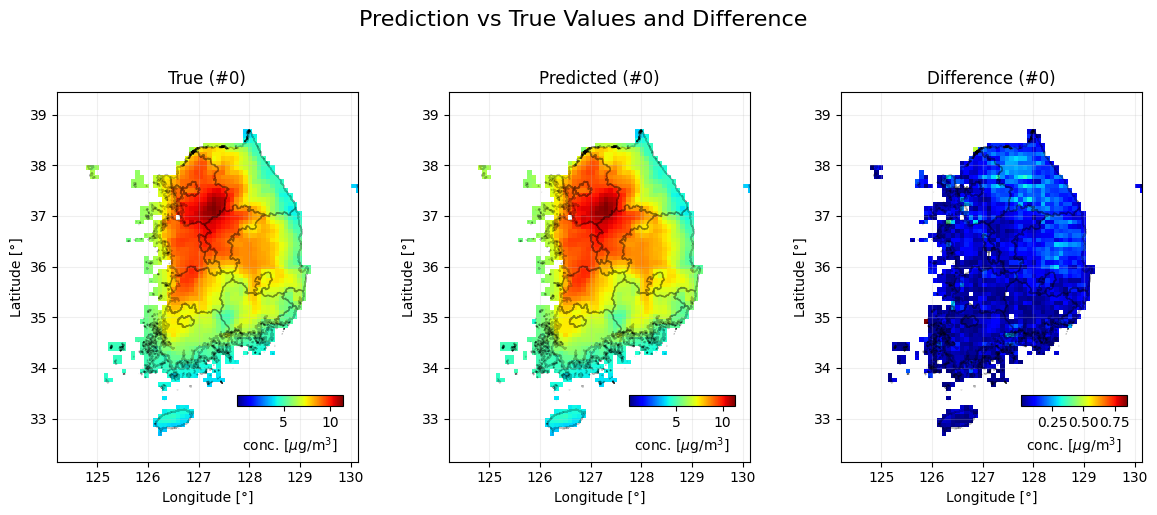

In [12]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=0)